# MP2 - Deconvolution

----------------

# Contents:
- **2D Deconvolution using Richardson-Lucy (RL) Algorithm [45 points]**
    - Implement RL algorithm [30]
    - Apply and visualize (2D astro image) [5]
    - Find plausible PSF for a given noisy brain image, comment, and plot [10]
- **3D Convolution [35 points]**
    - Implement 3D convolution [30]
    - Compare implementation with scipy [5]
- **3D Deconvolution using RL Algorithm [20 points]**
    - Implement 3D RL algorithm [15]
    - Apply and visualize (3D brain volumes) [5]
----------------

# [Section] 2D Deconvolution using Richardson-Lucy (RL) Algorithm [45 points]

In [1]:
import seaborn as sns
import os
import pandas

In [2]:
!pip install scikit-image
!curl https://upload.wikimedia.org/wikipedia/commons/0/03/T1-weighted-MRI.png --output brain_MRI.png

Defaulting to user installation because normal site-packages is not writeable
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 87581  100 87581    0     0   351k      0 --:--:-- --:--:-- --:--:--  350k


## Put your ```convolution2d``` function from MP1 in the cell below


In [2]:
import numpy as np
import math
from matplotlib import pyplot as plt

In [3]:
def convolve2D(image, kernel, padding=0, strides=1):
    '''
    Returns the result Y = image * kernel, where * is the 2-D convolution operator.

        Parameters:
                image (ndarray): 2-D input image/signal
                kernel (ndarray): 2-D convolution kernel/signal

        Returns:
                Y (ndarray): 2-D convolution result similar to "same" mode in scipy/numpy.
    '''
    kernel = np.flipud(np.fliplr(kernel))
    padding = (len(kernel) - 1) / 2
    padding = math.ceil(padding)
    
    xKernShape = kernel.shape[0]
    yKernShape = kernel.shape[1]
    
    output = np.zeros(image.shape)
    resize = []
    if (len(kernel) % 2 == 0):
        resize = np.zeros((len(image) + padding, len(image[0]) + padding))
    else:
        resize = np.zeros((len(image) + 2*padding, len(image[0]) + 2*padding))
        
    #fill in image resized:
    for i in range(len(image)):
        for j in range(len(image[0])):
            resize[i + padding][j + padding] = image[i][j]    
    
    for y in range(image.shape[1]):
        for x in range(image.shape[0]):
            output[x, y] = (kernel * resize[x: x + xKernShape, y: y + yKernShape]).sum()
    
    return output

### [Exercise] Implement the Richardson-Lucy deconvolution algorithm [30]
You should use your `convolve2D` function in the implementation. 

**Hint:** Make sure to use 'same' padding so that the convolution result has the same shape after each iteration.

In [129]:
from scipy.signal import convolve

def richardson_lucy(image, psf, num_iter=50, eps=1e-14):
    """
    Richardson-Lucy deconvolution.
    
    ----------
    input:
    image (Numpy.Array): Input degraded image (can be N dimensional).
    psf (ndarray): The point spread function.
    num_iter (int): Number of iterations. This parameter plays the role of regularisation. default to 50.
    eps (float): Optional. Value below which intermediate results become 0 to avoid division by small numbers.

    output: (Numpy.Array) The deconvolved image.
    """
    #assert(psf.sum() == 1)
    psf_flip = np.transpose(psf)
    output = np.ones(image.shape)
    
    for i in range(num_iter):
        conv = convolve2D(output, psf) + eps
        rel_blur = image / conv
        output = output * convolve2D(rel_blur, psf_flip)
    
    return output

Now let's try your R-L algorithm. First, load an image in grayscale.

In [90]:
import numpy as np
import matplotlib.pyplot as plt

from skimage import color, data, restoration

rng = np.random.default_rng()

astro = color.rgb2gray(data.astronaut())

Now manually add convolutional optical noise to the image by convolving the image with a point spread function (psf). Then add poisson noise to it.


In [91]:
psf = np.ones((5, 5)) / 25
astro = convolve(astro, psf, mode='same')

# add Noise to Image
astro_noisy = astro.copy()
astro_noisy += (rng.poisson(lam=25, size=astro.shape) - 10) / 255.

In [92]:
np.allclose(astro_noisy, astro)

False

### [Exercise] Now apply the Richardson Lucy deconvolution algorithm, and plot the original image, the image with noise, and the deconvolution result. [5]

In [93]:
# Restore noisy image using Richardson-Lucy algorithm
deconvolved_RL = richardson_lucy(astro_noisy, psf)

deconv_scipy = restoration.richardson_lucy(astro_noisy, psf, num_iter=50)

# Plot 1) original image, 2) noisy image, 3) deconvolution result side-by-side

Text(0.5, 1.0, 'deconv_skimage')

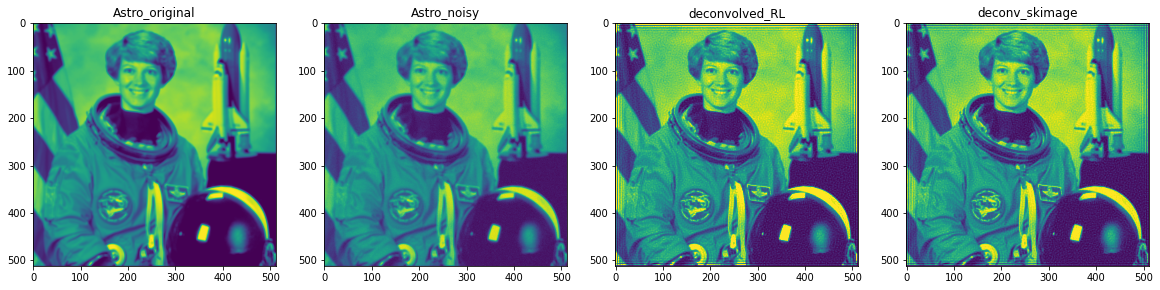

In [94]:
fig, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize=(20, 20))
ax1.imshow(astro)
ax1.set_title('Astro_original')

ax2.imshow(astro_noisy)
ax2.set_title("Astro_noisy")

ax3.imshow(deconvolved_RL, vmin=0, vmax=1)
ax3.set_title("deconvolved_RL")

ax4.imshow(deconv_scipy, vmin=0, vmax=1)
ax4.set_title("deconv_skimage")

In [77]:
#compare my RL vs skimage
np.allclose(deconvolved_RL, deconv_scipy)

False

In [78]:
print(deconvolved_RL)
print("-----------------------------------")
print(deconv_scipy)

[[5.22292614e-19 6.89366794e-14 4.73718377e-10 ... 1.91111641e-09
  2.47765359e-13 5.82612663e-19]
 [2.05984162e-13 3.73330417e-08 2.69757871e-04 ... 5.43746113e-04
  6.85473348e-08 1.62814097e-13]
 [3.59616197e-09 7.13041654e-04 5.51904465e+00 ... 4.55828035e+00
  5.46826552e-04 1.39475886e-09]
 ...
 [2.27299725e-09 8.32508057e-04 5.90718281e+00 ... 1.41598531e+00
  3.19431300e-05 1.75614089e-10]
 [1.91548777e-13 7.69086496e-08 5.30798517e-04 ... 1.42832381e-04
  2.70220164e-09 1.04628075e-14]
 [4.50476041e-19 2.09785402e-13 1.48134127e-09 ... 5.63295031e-10
  7.14283053e-15 2.08421168e-20]]
-----------------------------------
[[5.22292614e-19 6.89366794e-14 4.73718377e-10 ... 1.91111641e-09
  2.47765359e-13 5.82612663e-19]
 [2.05984162e-13 3.73330417e-08 2.69757871e-04 ... 5.43746113e-04
  6.85473348e-08 1.62814097e-13]
 [3.59616197e-09 7.13041654e-04 1.00000000e+00 ... 1.00000000e+00
  5.46826552e-04 1.39475886e-09]
 ...
 [2.27299725e-09 8.32508057e-04 1.00000000e+00 ... 1.00000000e

Now that we have seen the power of the Richardson Lucy algorithm with artificial/known noise, let's try it out on an image with real unknown noise.

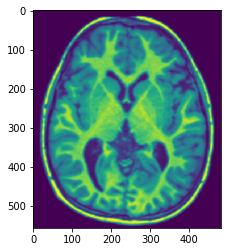

In [79]:
import PIL
brain = np.array(PIL.Image.open("brain_MRI.png"))


if len(brain.shape) > 2: # check if the picture has multiple color channels. If yes, convert to greyscale
    brain = color.rgb2gray(brain) 

plt.imshow(brain)
    
brain = brain / 256.  # normalize the image pixel data to [0,1]
brain += 1E-12 # adding a small constant 1E-12 to avoid division-by-zero later down the line

In [130]:
arr1 = np.array([[-1,0,0],
        [0,3,0],
        [0,0,-1]])

arr2 = np.array([[-1,-1,-1],
        [-1,9,-1],
        [-1,-1,-1]])

arr3 = np.array([[0,0,0],
        [0,1,0],
        [0,0,0]])

arr4 = np.array([[-1,0,-1],
        [0,5,0],
        [-1,0,-1]])

### [Exercise] Since we do not know the real psf function in this case, we have to make a guess. Find the psf function which best models the real convolutional noise by trying different psf values in the cell below. [10]

In [113]:
arrs = [arr1, arr2, arr3, arr4]
results = []
i = 0
for arr in arrs:
    print(f"array{i} : {arr}")
    res = richardson_lucy(brain, arr)
    results.append(res)
    i += 1
    print()

array0 : [[-1  0  0]
 [ 0  3  0]
 [ 0  0 -1]]

array1 : [[-1 -1 -1]
 [-1  9 -1]
 [-1 -1 -1]]

array2 : [[0 0 0]
 [0 1 0]
 [0 0 0]]

array3 : [[-1  0 -1]
 [ 0  5  0]
 [-1  0 -1]]



Text(0.5, 1.0, 'arr3')

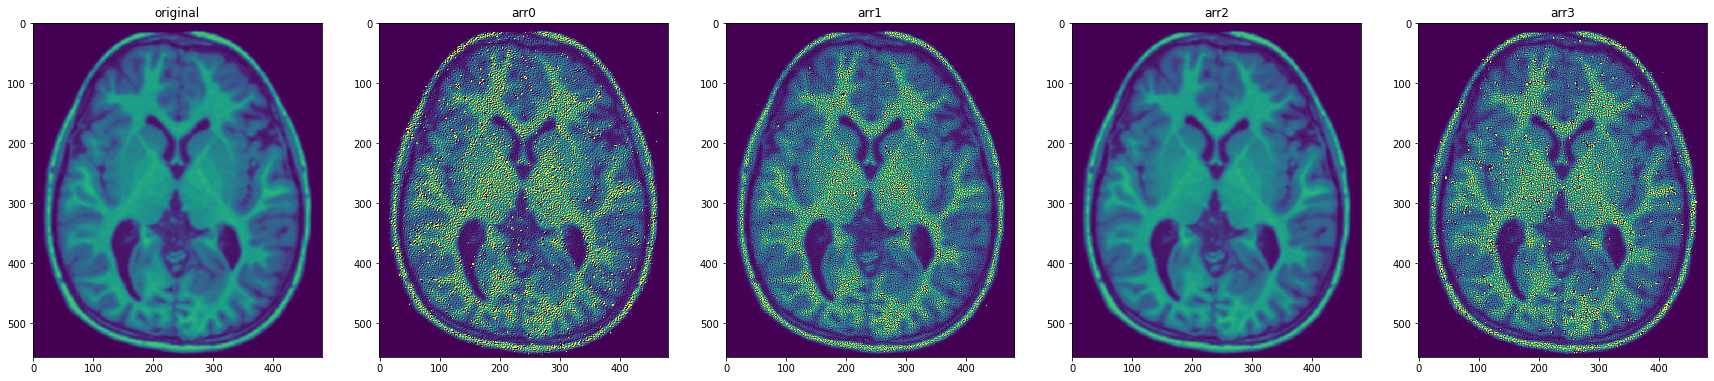

In [116]:
fig, (ax1, ax2, ax3, ax4, ax5) = plt.subplots(1, 5, figsize=(30, 30))

i = 0
ax1.imshow(brain, vmin=0, vmax=1)
ax1.set_title("original")

ax2.imshow(results[0], vmin=0, vmax=1)
ax2.set_title(f"arr{i}")
i+=1
ax3.imshow(results[1], vmin=0, vmax=1)
ax3.set_title(f"arr{i}")
i+=1
ax4.imshow(results[2], vmin=0, vmax=1)
ax4.set_title(f"arr{i}")
i+=1
ax5.imshow(results[3], vmin=0, vmax=1)
ax5.set_title(f"arr{i}")

/tmp/ipykernel_4157458/320875087.py:23: RuntimeWarning: overflow encountered in multiply
  output = output * convolve(rel_blur, psf_flip, mode="same")


Text(0.5, 1.0, 'deconv2x2')

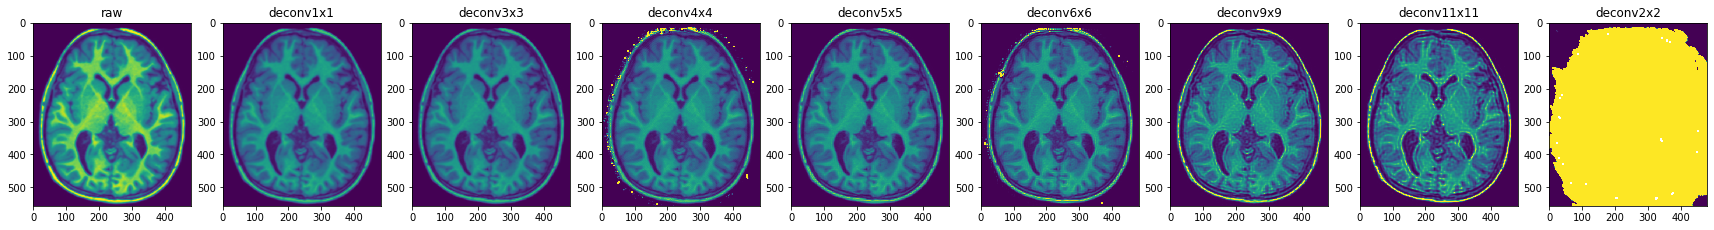

In [81]:
arr = [1, 3, 4, 5, 6, 9, 11, 2]
deconv = []
for i in arr:
    psf = np.ones((i, i)) / i**2
    res = richardson_lucy(brain, psf)
    deconv.append(res)
# psf = np.ones((5, 5)) / 25
# deconvolved_brain = richardson_lucy(brain, psf)


# visualize original and deconv output side-by-side
fig, (ax1, ax2, ax3, ax4, ax5, ax6, ax7, ax8, ax9) = plt.subplots(1, 9, figsize=(30, 30))
ax1.imshow(brain)
ax1.set_title("raw")

ax2.imshow(deconv[0], vmin=0, vmax=1)
ax2.set_title("deconv1x1")

ax3.imshow(deconv[1])
ax3.set_title("deconv3x3")

ax4.imshow(deconv[2], vmin=0, vmax=1)
ax4.set_title("deconv4x4")

ax5.imshow(deconv[3], vmin=0, vmax=1)
ax5.set_title("deconv5x5")

ax6.imshow(deconv[4], vmin=0, vmax=1)
ax6.set_title("deconv6x6")

ax7.imshow(deconv[5], vmin=0, vmax=1)
ax7.set_title("deconv9x9")

ax8.imshow(deconv[6], vmin=0, vmax=1)
ax8.set_title("deconv11x11")

ax9.imshow(deconv[7], vmin=0, vmax=1)
ax9.set_title("deconv2x2")

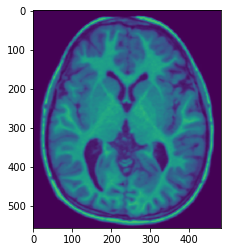

In [82]:
plt.imshow(brain, vmin=0, vmax=1)

**Q:** What did you observe when trying different point spread functions? Can you explain your observations?

**Your Answer:**
- For my first exploration, I tried the method of using 3x3 PSF kernels with differing elements; however, the sum of all the matrices equated to 1. I tried varying patterns of the kernel that were designed with different centering schemes and negative elements. Based on the results, it can be seen that 3 of the four deconvolutions resulted in a high amount of artifact and noise within the brain scan. I think this can be attributed to unjustified masking in the kernels targeting diagonals, center and edge properties within the image, ultimately resulting in noise not present in the original image with noise.

- I explored size next, and I noticed that with increasing size of point spread function, the image's color gradient is altered as a result of the PSF. The PSF is simply a mathematical formula that models how point source light is spread across a plane, affecting the emission of a the raw image visual After increasing the dimensions of the PSF matrix, the deconvolved image resulted in decrease in shading, a more outlined image, and as sharper image overall. Based on my results shown above, I believe that increasing the size of the PSF will affect the magnitude of deconvolution occurring thereby removing more blur. Since the sum, of my PSFs are all equal to one, I think the dimensionality affects the points source. Also, even-dimensioned PSFs result in artifacts that distort the original image.

## 2d check

In [16]:
def convolve2D(image, kernel):
    '''
    Returns the result Y = image * kernel, where * is the 2-D convolution operator.

        Parameters:
                image (ndarray): 2-D input image/signal
                kernel (ndarray): 2-D convolution kernel/signal

        Returns:
                Y (ndarray): 2-D convolution result similar to "same" mode in scipy/numpy.
    '''  
    # Cross Correlation
    kernel = np.flipud(np.fliplr(kernel))
    #padding = (len(kernel) - 1) / 2
    padding = math.ceil((len(kernel) - 1) / 2)
    
    xKernShape = kernel.shape[0]
    yKernShape = kernel.shape[1]
    
    output = np.zeros(image.shape)
    resize = []
    if (len(kernel) % 2 == 0):
        resize = np.zeros((len(image) + padding, len(image[0]) + padding))
    else:
        resize = np.zeros((len(image) + 2*padding, len(image[0]) + 2*padding))
        
    #fill in image resized:
    for i in range(len(image)):
        for j in range(len(image[0])):
            resize[i + padding][j + padding] = image[i][j]    
    
    for y in range(image.shape[1]):
        for x in range(image.shape[0]):
            output[x, y] = (kernel * resize[x: x + xKernShape, y: y + yKernShape]).sum()
    
    return output

In [17]:
image = np.array([[1,2,3],[2,3,4],[4,4,4],[-1,0,1]]) # 4 x 3
kernel = np.array([[1,2],[2,3.7]]) # 2 x 2


#image = np.array([[1,2,3,4],[2,3,4, 69.1],[4,4,4, -58],[-1,0,1, 69.69]]) # 4 x 4
#kernel = np.array([[1,2,0.5],[2,3.7,0.9],[12, 24, 18]]) # 3 x 3

#image = np.random.random((6,6))
#kernel = np.random.random((3,3))

print(kernel.shape)

print("Image :")
print(image)

print("kernel :")
print(np.flipud(np.fliplr(kernel)))

print("Correct (Scipy) Result:")
from scipy.signal import convolve2d
np_result = convolve2d(image, kernel, mode="same", boundary='fill', fillvalue=0)
print(np_result) # 4 x 3 - same as input since mode="same"

print()

print("Your Answer:")
your_result = convolve2D(image, kernel)
print(your_result)

print("\nYour result is {}".format("correct!" if np.array_equal(
    np_result, your_result) else "incorrect."))


print(" \n no difference?")
print(np.allclose(your_result, np_result))

(2, 2)
Image :
[[ 1  2  3]
 [ 2  3  4]
 [ 4  4  4]
 [-1  0  1]]
kernel :
[[3.7 2. ]
 [2.  1. ]]
Correct (Scipy) Result:
[[ 1.   4.   7. ]
 [ 4.  14.7 23.4]
 [ 8.  25.4 31.1]
 [ 7.  20.8 23.8]]

Your Answer:
[[ 1.   4.   7. ]
 [ 4.  14.7 23.4]
 [ 8.  25.4 31.1]
 [ 7.  20.8 23.8]]

Your result is correct!
 
 no difference?
True


--------------------
# [Section] 3D Convolution [35 points]

Now let's apply the Richardson-Lucy algorithm in the 3-D space. 

In [29]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.signal import convolve as scipy_convolve

### [Exercise] Implement the 3D convolution [30]

First, implement the 3-D convolution function in the cell below. Your implementation must support arbitrary padding modes.

In [30]:
def convolve3D(image, kernel, padding=0):
    '''
    convolve3D takes in the image array and the kernel array and convolves them
    with the padding scheme specified by parameter "padding"

    Input:
    image (Numpy.Array): 3-D image to be convolved
    kernel (Numpy.Array): 3-D kernel to be convolved
    padding (int): padding mode. default is 0

    Output:
    result (Numpy.Array): result of the convolution between image and kernel
    '''
    kernel = np.flip(kernel)

    # Gather Shapes of Kernel + Image + Padding
    xKernShape = kernel.shape[0]
    yKernShape = kernel.shape[1]
    zKernShape = kernel.shape[2]
    padding = (math.floor(xKernShape / 2), math.floor(yKernShape / 2), math.floor(zKernShape / 2))
    
    xImgShape = image.shape[0]
    yImgShape = image.shape[1]
    zImgShape = image.shape[2]

    # Shape of Output Convolution
    if xKernShape % 2 == 0:
        xOutput = int((xImgShape - xKernShape + 2 * padding[0]))
    else:
        xOutput = int((xImgShape - xKernShape + 2 * padding[0]) + 1)
        
    if yKernShape % 2 == 0:
        yOutput = int((yImgShape - yKernShape + 2 * padding[1]))
    else:
        yOutput = int((yImgShape - yKernShape + 2 * padding[1]) + 1)
    
    if zKernShape % 2 == 0:
        zOutput = int((zImgShape - zKernShape + 2 * padding[2]))
    else:
        zOutput = int((zImgShape - zKernShape + 2 * padding[2]) + 1)

    output = np.zeros((xOutput, yOutput, zOutput))

    # Apply Equal Padding to All Sides
    if padding != 0:
        imagePadded = np.zeros((image.shape[0] + padding[0]*2, image.shape[1] + padding[1]*2, image.shape[2] + padding[2]*2))
        imagePadded[int(padding[0]):int(-1 * padding[0]), int(padding[1]):int(-1 * padding[1]), int(padding[2]):int(-1 * padding[2])] = image
        # print(imagePadded)
    else:
        imagePadded = image

    # Iterate through image
    for z in range(image.shape[2]):
        if z > image.shape[2] - zKernShape + 2*padding[2]:
            break
        for y in range(image.shape[1]):
            # Exit Convolution
            if y > image.shape[1] - yKernShape + 2*padding[1]:
                break
            # Only Convolve if y has gone down by the specified Strides

            for x in range(image.shape[0]):
                # Go to next row once kernel is out of bounds
                if x > image.shape[0] - xKernShape + 2*padding[0]:
                    break
                try:
                    # Only Convolve if x has moved by the specified Strides
                    output[x, y, z] = (kernel * imagePadded[x: x + xKernShape, y: y + yKernShape, z: z + zKernShape]).sum()
                except:
                    break

    return output

### [Exercise] Test your 3-D convolution function in the cell below. [5]

In [6]:
A = np.random.randint(0, 100, size=(30, 10, 18))
#A = np.random.randint(0, 100, size=(6, 6, 6))
B = np.random.randint(0, 100, size=(5,5,3))
# padding = (len(B) - 1) / 2
# padding = math.ceil(padding)

#print(B.shape)


#print(A)
#print(B)

print("Correct (Scipy) Result:")
scipy_result = scipy_convolve(A, B, mode="same")
print(scipy_result.shape)
print(scipy_result)


print("Your Answer:")
your_result = convolve3D(A, B, padding=0)
print(your_result.shape)
print(your_result)


print("\nYour result is {}".format("correct!" if np.array_equal(
    scipy_result, your_result) else "incorrect."))

Correct (Scipy) Result:
(30, 10, 18)
[[[ 36644  82572  71791 ...  64466  75716  47201]
  [ 58533  76931  82661 ...  70159  94582  75107]
  [ 68183 114895 121845 ...  89587  95077  90595]
  ...
  [ 88058 117591 118068 ... 133179 118332  93992]
  [ 67542  94029 101959 ... 104122 103315  77268]
  [ 44369  74319  60650 ...  70273  71509  60763]]

 [[ 62614 102155  86668 ...  88372  90736  77750]
  [ 70417 115794 119916 ... 111652 124072  89497]
  [ 87260 148014 127703 ... 142402 162128 133858]
  ...
  [101572 152977 158922 ... 171291 164960 115866]
  [ 95394 144883 120247 ... 138612 133532  98798]
  [ 61783 101149 103730 ... 108763 107766  76844]]

 [[ 78512 133081 126621 ... 116822 117210  80358]
  [111353 162476 161262 ... 132231 143122 121858]
  [118385 206348 197946 ... 204105 195722 145486]
  ...
  [135020 200961 191879 ... 196487 203703 129703]
  [107360 156709 174217 ... 164973 166859 112642]
  [ 78109 125532 127833 ... 133972 126075  88635]]

 ...

 [[ 75453 110518 120305 ... 10665

You are encouraged to try different kernel sizes and padding modes to ensure your implementation is robust and general.

--------------

# [Section] 3D Deconvolution using RL Algorithm [20 points]

### [Exercise] Now with the 3D convolution function, implement the 3D Richardson-Lucy deconvolution algorithm. If your 3D convolution function does not work, use a library implementation instead. [15]

In [44]:
def richardson_lucy_3d(image, psf, padding, num_iter=30, eps=1e-12):
    """Richardson-Lucy deconvolution.
    Parameters
    ----------
    image : ndarray
      Input degraded image (can be N dimensional).
    psf : ndarray
      The point spread function.
    eps: float, optional
      Value below which intermediate results become 0 to avoid division
      by small numbers.
    padding: int
      Value depends on size of psf used. Use the padding size in the "same" padding mode.
    num_iter : int, optional
      Number of iterations. This parameter plays the role of
      regularisation.
    Returns
    -------
    im_deconv : ndarray
      The deconvolved image.
    """
    #assert(math.floor(psf.sum()) == 1)
    psf_t = np.transpose(psf)
    output = np.ones(image.shape)
    
    for i in range(num_iter):
        conv = convolve3D(output, psf, padding=0) + eps
        rel_blur = image / conv
        output = output * convolve3D(rel_blur, psf_t, padding=0)
    
    return output

In [19]:
import nibabel as nib
from skimage import color

!wget https://github.com/vb100/Visualize-3D-MRI-Scans-Brain-case/raw/master/data/images/BRATS_001.nii.gz

--2022-10-19 14:26:51--  https://github.com/vb100/Visualize-3D-MRI-Scans-Brain-case/raw/master/data/images/BRATS_001.nii.gz
Resolving github.com (github.com)... 140.82.112.4
Connecting to github.com (github.com)|140.82.112.4|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/vb100/Visualize-3D-MRI-Scans-Brain-case/master/data/images/BRATS_001.nii.gz [following]
--2022-10-19 14:26:51--  https://raw.githubusercontent.com/vb100/Visualize-3D-MRI-Scans-Brain-case/master/data/images/BRATS_001.nii.gz
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.108.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10641910 (10M) [application/octet-stream]
Saving to: ‘BRATS_001.nii.gz.1’

BRATS_001.nii.gz.1  100%[===================>]  10.15M  --.-KB/s    in 0.1s    

202

In [20]:
image_path = "BRATS_001.nii.gz"
image_obj = nib.load(image_path)
image_data = image_obj.get_fdata()
type(image_data)
print(image_data.shape)
image_data_by_channel = np.array([image_data[:, :, :, i] for i in range(4)])
print(image_data_by_channel.shape)

(240, 240, 155, 4)
(4, 240, 240, 155)


The amount of computation in 3D deconvolution / convolution is exponentially higher than in the 2D space. To save some time, let's shrink the image by downsampling it to a factor of 0.7 in the cell below. You may choose different factors to test your implementation faster.

In [21]:
from scipy.ndimage import zoom

image_data_by_channel = np.array(
    [zoom(channel, (0.7, 0.7, 0.7)) for channel in image_data_by_channel])

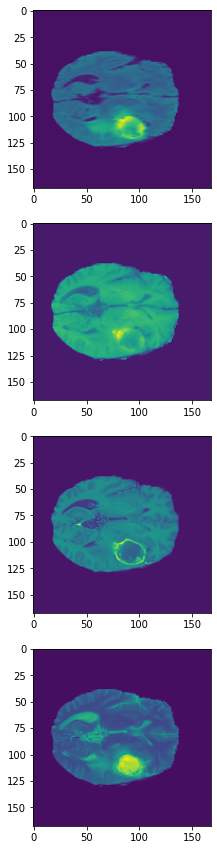

In [13]:
fig, axs = plt.subplots(4, figsize=(15, 15))
j = 0
for channel in image_data_by_channel:
    axs[j].imshow(channel[:, :, 50])
    j+=1

In [31]:
rng = np.random.default_rng()

psf = np.ones((5, 5, 5)) / 125

convolved_by_channel = [scipy_convolve(
    channel_slice, psf) for channel_slice in image_data_by_channel]

noisy_by_channel = convolved_by_channel.copy()

noisy_by_channel = [channel_slice + (rng.poisson(lam=125, size=channel_slice.shape) - 10 / 255)
                    for channel_slice in noisy_by_channel]
#np.save("noisy_by_channel.npy", noisy_by_channel)

### [EXERCISE] Finally, let's apply your 3-D Richardson-Lucy deconvolution implementation to the noisy volumetric brain image.[5]

**(Warning - num_iter=1 in the cell below may take 3-6mins to run!)**

In [ ]:
#num_iter = 50
li = []

for i in noisy_by_channel:
    deconvolved_result = richardson_lucy_3d(i, psf, num_iter=20, padding=0)
    li.append(deconvolved_result)
#ran python script in action.py

In [33]:
noisy_by_channel = np.load("noisy_by_channel.npy")

In [119]:
#executed python script to save results
li = np.load("results3.npy")

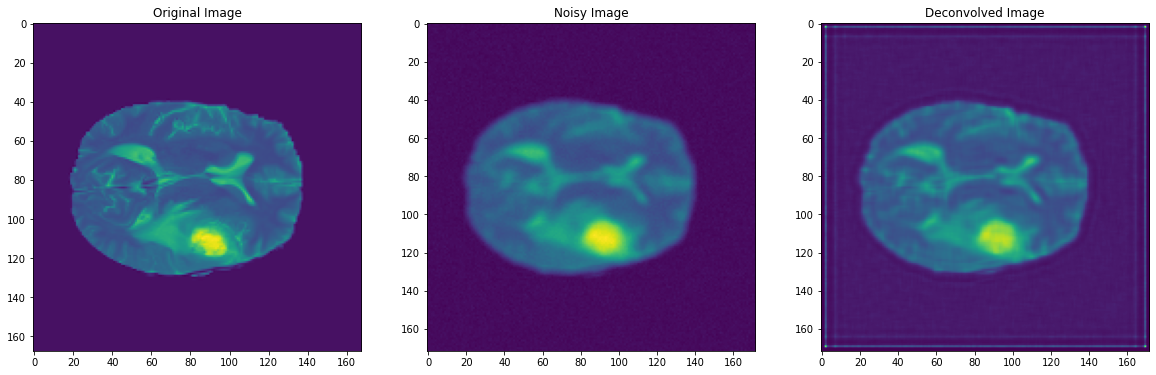

In [141]:
def display_deconvolution_comparison(layer_idx, channel_slice_idx):
    '''
    Display the original, noisy, and deconvolved image side-by-side given a particular 2D slice of the 4D brain image dataset.
    '''
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20, 20))
    
    
    ax1.imshow(image_data_by_channel[channel_slice_idx][:,:,layer_idx])
    ax1.set_title("Original Image")
    
    ax2.imshow(noisy_by_channel[channel_slice_idx][:,:,layer_idx])
    ax2.set_title("Noisy Image")
    
    ax3.imshow(li[channel_slice_idx][:,:,layer_idx])
    ax3.set_title("Deconvolved Image")
    
    return

layer_idx = 54 #range of 108
channel_slice_idx = 3 #range of 4
display_deconvolution_comparison(layer_idx, channel_slice_idx)

In [88]:
A = np.random.randint(0, 100, size=(30, 10, 18))
print(np.transpose(A).shape)
print(np.flip(A).shape)

(18, 10, 30)
(30, 10, 18)


In [121]:
print(li[0])

[[[9.86208437e-07 6.27274196e-05 1.55787840e-03 ... 1.04858618e-03
   4.36386744e-05 5.72808199e-07]
  [6.02027815e-05 4.17808342e-03 1.07061436e-01 ... 7.86520740e-02
   3.26799779e-03 4.35241638e-05]
  [1.59931488e-03 1.12748575e-01 2.84815331e+00 ... 2.43364757e+00
   9.10333837e-02 1.19625103e-03]
  ...
  [7.88677458e-04 7.63449423e-02 2.52959978e+00 ... 2.51132588e+00
   7.90811236e-02 9.21389040e-04]
  [2.60487013e-05 2.42995756e-03 8.02890413e-02 ... 8.59298788e-02
   2.71000104e-03 2.91059789e-05]
  [3.26517874e-07 2.81859963e-05 1.00459874e-03 ... 9.79323457e-04
   3.00018869e-05 2.99044779e-07]]

 [[6.73032827e-05 4.77090177e-03 1.20082700e-01 ... 9.30368338e-02
   3.79892935e-03 4.91981965e-05]
  [4.30464194e-03 3.23339849e-01 8.32263984e+00 ... 6.85746862e+00
   2.82932909e-01 3.64403188e-03]
  [1.17246029e-01 8.79591776e+00 2.24763378e+02 ... 2.09437216e+02
   7.86905796e+00 1.01453279e-01]
  ...
  [7.18059450e-02 6.39226861e+00 2.02887310e+02 ... 2.13237337e+02
   6.75951

In [142]:
from mpl_toolkits.mplot3d import Axes3D

-----------

## Testing Skimage

In [122]:
psf = np.ones((5, 5, 5)) / 125
skimage = restoration.richardson_lucy(noisy_by_channel[0], psf, num_iter=20)
mine = li[0]

In [126]:
print(mine[1])
print("---------------------------")
print(skimage[1])
np.allclose(mine,skimage)

[[6.73032827e-05 4.77090177e-03 1.20082700e-01 ... 9.30368338e-02
  3.79892935e-03 4.91981965e-05]
 [4.30464194e-03 3.23339849e-01 8.32263984e+00 ... 6.85746862e+00
  2.82932909e-01 3.64403188e-03]
 [1.17246029e-01 8.79591776e+00 2.24763378e+02 ... 2.09437216e+02
  7.86905796e+00 1.01453279e-01]
 ...
 [7.18059450e-02 6.39226861e+00 2.02887310e+02 ... 2.13237337e+02
  6.75951109e+00 8.19944832e-02]
 [2.43751951e-03 2.08058341e-01 6.60287546e+00 ... 7.24618890e+00
  2.29488955e-01 2.57304757e-03]
 [3.13707200e-05 2.47817274e-03 8.31837533e-02 ... 8.39059719e-02
  2.56348831e-03 2.76744147e-05]]
---------------------------
[[6.73032827e-05 4.77090177e-03 1.20082700e-01 ... 9.30368338e-02
  3.79892935e-03 4.91981965e-05]
 [4.30464194e-03 3.23339849e-01 1.00000000e+00 ... 1.00000000e+00
  2.82932909e-01 3.64403188e-03]
 [1.17246029e-01 1.00000000e+00 1.00000000e+00 ... 1.00000000e+00
  1.00000000e+00 1.01453279e-01]
 ...
 [7.18059450e-02 1.00000000e+00 1.00000000e+00 ... 1.00000000e+00
  1.

False

In [128]:
import os
os.path.getsize("results.npy")

106029184